In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import cv2
import numpy as np

DATASET_ROOT = "/kaggle/input/pcb-defect-dataset/PCB_DATASET"
TEMPLATE_DIR = f"{DATASET_ROOT}/PCB_USED"
IMAGE_DIR = f"{DATASET_ROOT}/images"

OUTPUT_ROOT = "/kaggle/working/outputs"


In [2]:
DEFECTS = [
    "Missing_hole",
    "Mouse_bite",
    "Open_circuit",
    "Short",
    "Spur",
    "Spurious_copper"
]

for d in DEFECTS:
    os.makedirs(f"{OUTPUT_ROOT}/{d}/annotated", exist_ok=True)
    os.makedirs(f"{OUTPUT_ROOT}/{d}/masks", exist_ok=True)
    os.makedirs(f"{OUTPUT_ROOT}/{d}/rois", exist_ok=True)


In [3]:
def process_defect(defect_name, area_min, area_max):
    print(f"\nProcessing {defect_name}...")

    defect_path = f"{IMAGE_DIR}/{defect_name}"

    for img_name in os.listdir(defect_path):
        if not img_name.endswith(".jpg"):
            continue

        pcb_id = img_name.split("_")[0]          # e.g. 01
        template_path = f"{TEMPLATE_DIR}/{pcb_id}.JPG"

        template = cv2.imread(template_path)
        defect = cv2.imread(f"{defect_path}/{img_name}")

        if template is None or defect is None:
            continue

        # --- preprocessing ---
        t_gray = cv2.GaussianBlur(
            cv2.cvtColor(template, cv2.COLOR_BGR2GRAY), (5,5), 0)
        d_gray = cv2.GaussianBlur(
            cv2.cvtColor(defect, cv2.COLOR_BGR2GRAY), (5,5), 0)

        diff = cv2.absdiff(t_gray, d_gray)
        _, mask = cv2.threshold(diff, 0, 255,
                                 cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        contours, _ = cv2.findContours(
            mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        annotated = defect.copy()

        roi_count = 0
        for c in contours:
            area = cv2.contourArea(c)
            if area_min < area < area_max:
                x,y,w,h = cv2.boundingRect(c)
                cv2.rectangle(annotated, (x,y), (x+w,y+h), (0,0,255), 2)

                roi = defect[y:y+h, x:x+w]
                cv2.imwrite(
                    f"{OUTPUT_ROOT}/{defect_name}/rois/{img_name}_{roi_count}.jpg",
                    roi
                )
                roi_count += 1

        cv2.imwrite(
            f"{OUTPUT_ROOT}/{defect_name}/annotated/{img_name}",
            annotated
        )
        cv2.imwrite(
            f"{OUTPUT_ROOT}/{defect_name}/masks/{img_name}",
            mask
        )


In [4]:
process_defect("Missing_hole",      50, 800)
process_defect("Mouse_bite",       200, 1500)
process_defect("Open_circuit",     400, 5000)
process_defect("Short",            400, 5000)
process_defect("Spur",              80, 600)
process_defect("Spurious_copper",  300, 3000)

print("\nMilestone-1 completed for ALL defects")



Processing Missing_hole...

Processing Mouse_bite...

Processing Open_circuit...

Processing Short...

Processing Spur...

Processing Spurious_copper...

Milestone-1 completed for ALL defects


(-0.5, 3033.5, 1585.5, -0.5)

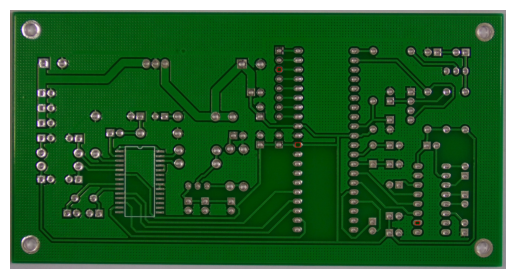

In [5]:
import matplotlib.pyplot as plt

img = cv2.imread(
    "/kaggle/working/outputs/Missing_hole/annotated/01_missing_hole_01.jpg"
)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")


In [6]:
import shutil

# Path to outputs folder
source_dir = "/kaggle/working/outputs"

# Zip file path (will appear in Output panel)
zip_path = "/kaggle/working/Milestone1_outputs"

# Create zip
shutil.make_archive(zip_path, 'zip', source_dir)

print("✅ Milestone1_outputs.zip created successfully")


✅ Milestone1_outputs.zip created successfully
